# fscLVM tutorial 

In this notebook we illustrate how f-scLVM can be used to identify biological drivers on the mESC cell cycle staged dataset.

First, we load some modules and set some directories

In [1]:
import sys
import os
import scipy as SP
import cPickle as pickle
import fscLVM
from fscLVM import plotFactors, plotFA, saveFA, dumpFA
%load_ext rpy2.ipython
%pylab inline

#specify where the hdf5 file is
data_dir = '../../../data/'
out_dir = './../results/'



Populating the interactive namespace from numpy and matplotlib


f-scLVM expects a hdf file containing the normalised, log transformed gene expression data as well as a set of annotations. We provide an R script (in the R folder) which can be used to generate this input from a gene expression matrix, using annotation from REACTOME or MSigDB. Alternatively, text files with annotations and normalised read counts can also be loaded in python.






# Loading data and model initialisation

Arguments specify some options, incuding number of hidden factors (`nHidden`), minimum number of genes in a pathway (`minGenes`), whether to use the fast option by pruning genes (`pruneGenes`), noise model (`noise`) and the data directory (`data_dir`).

In [2]:
#We provide an (optional) hdf file with the required data - this was generated using 
#the R script write_fscLVM.R in the R folder

#dFile = 'Buettneretal2015.hdf5'
#data = fscLVM.load_hdf5(dFile, data_dir=data_dir)

#Annotation file
annoFile = 'h.all.v5.0.symbols.gmt.txt' #MSigDB
#annoFile = 'c2.cp.reactome.v4.0.symbols.gmt.txt' #REACTOME
dataFile = 'Buettneretal.csv'

data = fscLVM.utils.load_txt(dataFile, annoFile, data_dir=data_dir)


I = data['I']
Y = data['Y']
terms = data['terms']


FA = fscLVM.initFA(Y, terms,I,noise='gauss', nHidden=3, 
                   pruneGenes=True, minGenes=15)

## Model training

In [3]:

#model training
FA.train()

#print diagnostics
FA.printDiagnostics()

iteration 0
iteration 100
iteration 200
iteration 300
iteration 400
iteration 500
iteration 600
iteration 700
Converged after 701 iterations
('Maximally ', 4.6875, '% Genes per factor changed.')


Next, we plot the results, including  factor relevance, gene set augmentation and a scatter plot of the two most relevant factors, in this case G2M Checkpoint and P53 Pathway. 

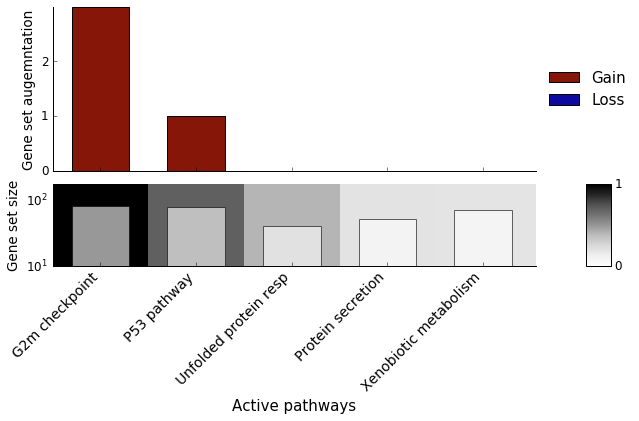

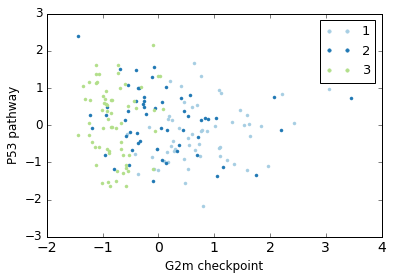

In [6]:
#plot resutls
fig = plotFA(FA)

#get factors; analogous getters are implemented for relevance and weights (see docs)
X = FA.getFactors(ids=['G2m checkpoint','P53 pathway'])

#scatter plot of the top two factors
plotFactors(X=X, lab=data['lab'], terms=['G2m checkpoint','P53 pathway'], isCont=False)


#the same plot can be generated by passing the FA object to the plot function
#plotFactors(FA=FA,idx1=0,idx2=1, lab = data['lab'], isCont=False )



In [11]:
#get changes genes ? 
changed=FA.getNchanged()
#explore changes to G2M checkpoint factor


Finally, we can dump the results in a dictionary and/or hdf file.

In [12]:
out_name = FA.getName()+'hdf5'
saveFA(FA, out_name=out_name, out_dir=out_dir)

dataFA = dumpFA(FA)
print dataFA.keys()

['terms', 'I', 'W', 'idx_genes', 'relevance', 'X', 'Z']
